In [19]:
import gymnasium as gym
import numpy as np

env = gym.make('FrozenLake-v1', render_mode='rgb_array', map_name="4x4", is_slippery=False)
state_space = env.observation_space.n
action_space = env.action_space.n
action_space, state_space

(np.int64(4), np.int64(16))

> There are 4 possible actions (Left, Down, Right, Up) and 16 possible states (4x4 grid) and 16 observation spaces.

## Showing the environment

/Users/geraldamasi/PycharmProjects/RL/.venv/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


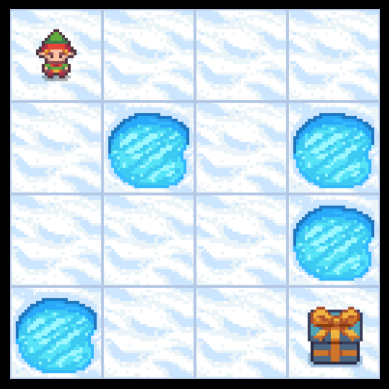

In [2]:
import matplotlib.pyplot as plt
env.reset()
img = env.render()
plt.imshow(img)
plt.axis('off')
plt.show()

## Value Iteration V(s) Q(s,a)

here we are trying to find the optimal value function for each state

In [5]:
value_table = np.zeros(state_space)
no_of_iterations = 10000
value_table # Show initial value table

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [26]:
def value_iteration(env, value_table, no_of_iterations, discount_factor=0.99):
    P = env.unwrapped.P  # Transition probabilities

    for _ in range(no_of_iterations):
        new_value_table = np.copy(value_table)

        for state in range(state_space):
            q_values = []

            for action in range(action_space):
                q_value = 0
                for prob, next_state, reward, done in P[state][action]:
                    q_value += prob * (reward + discount_factor * new_value_table[next_state])
                q_values.append(q_value)

            value_table[state] = max(q_values)

        if np.sum(np.abs(new_value_table - value_table)) < 1e-4:
            break

    return value_table

In [72]:
def extract_policy(env, value_table, discount_factor=0.99):
    P = env.unwrapped.P
    policy = np.zeros(state_space, dtype=int)

    for state in range(state_space):
        q_values = []

        for action in range(action_space):
            q_value = 0
            for prob, next_state, reward, done in P[state][action]:
                q_value += prob * (reward + discount_factor * value_table[next_state])
            q_values.append(q_value)

        policy[state] = np.argmax(q_values)
    return policy

In [73]:
optimal_value_function = value_iteration(env, value_table, no_of_iterations)
optimal_policy = extract_policy(env, optimal_value_function)
optimal_policy

array([1, 2, 1, 0, 1, 0, 1, 0, 2, 1, 1, 0, 0, 2, 2, 0])

In [74]:
prob, next_state, reward, done = env.unwrapped.P[0][1][0]
# val = env.unwrapped.P[0][1]
# prob, next_state, reward, done = val[0]
q_value = prob * (reward + 0.99 * value_table[next_state])
env.unwrapped.P[0], env.unwrapped.P[0][1], done, next_state, q_value

({0: [(1.0, 0, 0, False)],
  1: [(1.0, 4, 0, False)],
  2: [(1.0, 1, 0, False)],
  3: [(1.0, 0, 0, False)]},
 [(1.0, 4, 0, False)],
 False,
 4,
 np.float64(0.9509900498999999))

In [75]:
optimal_value_function

array([0.95099005, 0.96059601, 0.970299  , 0.96059601, 0.96059601,
       0.        , 0.9801    , 0.        , 0.970299  , 0.9801    ,
       0.99      , 0.        , 0.        , 0.99      , 1.        ,
       0.        ])

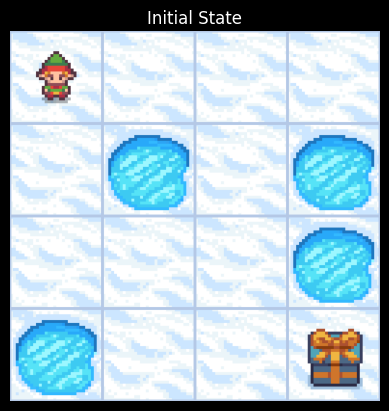

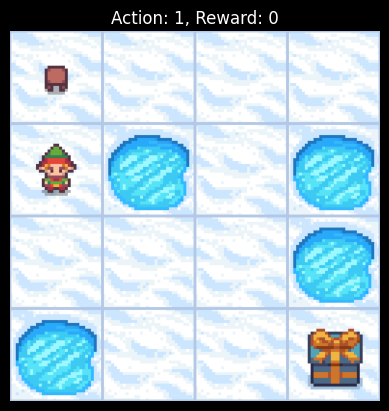

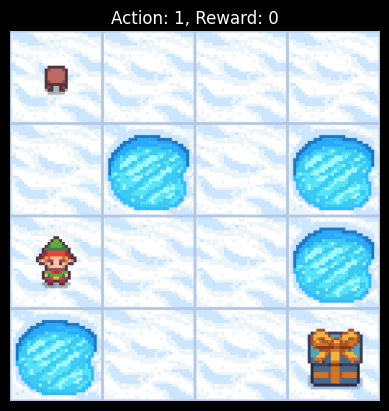

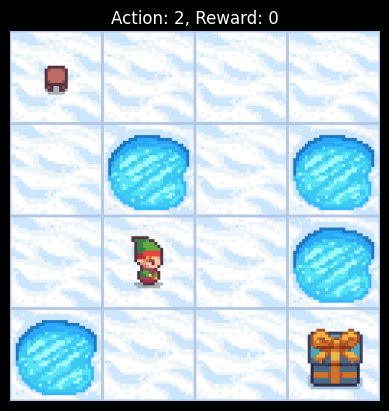

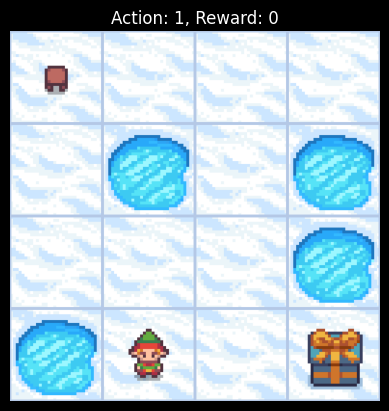

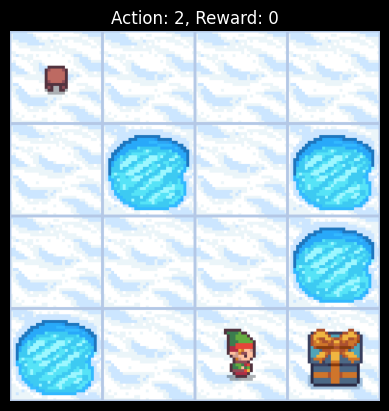

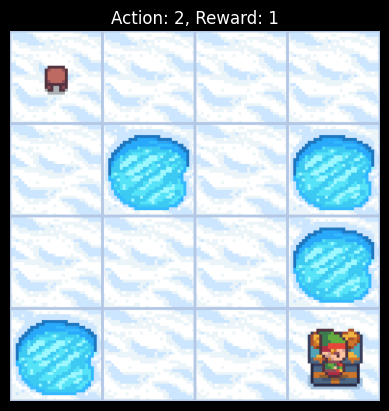

In [36]:
# Render visualization of the optimal policy
def render_policy(env, policy):
    state, info = env.reset()
    terminated = False
    truncated = False
    img = env.render()
    plt.imshow(img)
    plt.axis('off')
    plt.title("Initial State")
    plt.show()
    while not terminated and not truncated:
        action = policy[state]
        state, reward, terminated, truncated, info = env.step(action)
        img = env.render()
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Action: {action}, Reward: {reward}")
        plt.show()
render_policy(env, optimal_policy)

In [40]:
import imageio

def record_policy(env, policy, filename="optimal_policy.mp4", fps=2):
    frames = []
    state, info = env.reset()
    terminated = False
    truncated = False
    while not terminated and not truncated:
        frame = env.render()
        frames.append(frame)
        action = int(policy[state])
        state, reward, terminated, truncated, info = env.step(action)

    # Add final frame
    frames.append(env.render())
    imageio.mimsave(filename, frames, fps=fps)
record_policy(env, optimal_policy, filename='frozen_lake_optimal_policy.mp4', fps=1)

## Policy Iteration

In [81]:
def compute_value_function(policy, gamma=0.99):
    value_table = np.zeros(state_space)
    while True:
        new_value_table = np.copy(value_table)
        for state in range(state_space):
            action = policy[state]
            q_value = 0
            for prob, next_state, reward, done in env.unwrapped.P[state][action]:
                q_value += prob * (reward + gamma * new_value_table[next_state])
            value_table[state] = q_value
        if np.sum(np.abs(new_value_table - value_table)) < 1e-4:
            break
    return value_table

In [82]:
def extract_policy_from_value(value_table, gamma=0.99):
    policy = np.zeros(state_space, dtype=int)
    for state in range(state_space):
        q_values = []
        for action in range(action_space):
            q_value = 0
            for prob, next_state, reward, done in env.unwrapped.P[state][action]:
                q_value += prob * (reward + gamma * value_table[next_state])
            q_values.append(q_value)
        policy[state] = np.argmax(q_values)
    return policy

In [83]:
random_policy = np.random.choice(action_space, size=state_space)
random_policy

array([0, 1, 3, 1, 1, 0, 3, 3, 1, 0, 3, 2, 2, 0, 3, 3])

## Q-learning

Update formula: Q(s,a) = Q(s,a) + α [R(s,a) + γ max_a' Q(s',a') - Q(s,a)]

In [6]:
Q = np.zeros((state_space, action_space))

In [11]:
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_decay = 0.9999
min_epsilon = 0.01
num_episodes = 10000
for episode in range(num_episodes):
    state, info = env.reset()
    terminated = False
    truncated = False
    while not terminated and not truncated:
        if np.random.rand() < epsilon:
            action = env.action_space.sample()  # Explore
        else:
            action = np.argmax(Q[state])  # Exploit

        next_state, reward, terminated, truncated, info = env.step(action)

        # Q-learning update
        Q[state][action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][action])

        state = next_state
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

In [16]:
optimal_policy = np.argmax(Q, axis=1)

In [36]:
import imageio
def play_policy(env, policy, filename='frozenlake-qlearning-policy.mp4', fps=2):
    frames = []
    state, info = env.reset()
    terminated = False
    truncated = False
    while not terminated and not truncated:
        frame = env.render()
        frames.append(frame)
        action = int(policy[state])
        state, reward, terminated, truncated, info = env.step(action)
    frames.append(env.render())
    imageio.mimsave(filename, frames, fps=fps)
play_policy(env, optimal_policy, filename='frozenlake-qlearning-policy.mp4', fps=1)

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

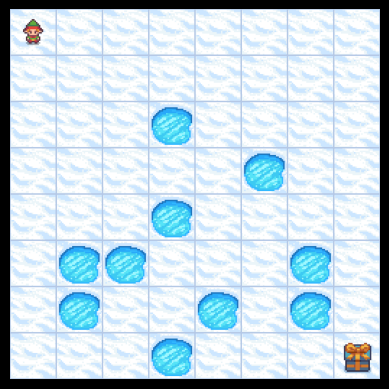

In [13]:
# Trial env
import matplotlib.pyplot as plt
trial_env = gym.make('FrozenLake-v1', render_mode='rgb_array', map_name="8x8", is_slippery=False)
action_space = trial_env.action_space.n
state_space = trial_env.observation_space.n
trial_env.reset()
img = trial_env.render()

plt.imshow(img)
plt.axis('off')

In [16]:
Q = np.zeros((state_space, action_space))
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_decay = 0.9999
min_epsilon = 0.01
num_episodes = 30000
for episode in range(num_episodes):
    state, info = trial_env.reset()
    terminated = False
    truncated = False
    while not terminated and not truncated:
        if np.random.rand() < epsilon:
            action = trial_env.action_space.sample()  # Explore
        else:
            action = np.argmax(Q[state])  # Exploit

        next_state, reward, terminated, truncated, info = trial_env.step(action)

        # Q-learning update
        Q[state][action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][action])

        state = next_state
    epsilon = max(min_epsilon, epsilon * epsilon_decay)
optimal_policy = np.argmax(Q, axis=1)
play_policy(trial_env, optimal_policy, filename='frozenlake-qlearning-policy-8x8.mp4', fps=2)

## Deep Q-Learning
There are alot to uncover here for Deep Q learning. I want to still use the example of Frozen Lake but with a neural network approximator instead of a Q table. Some other cases might be using Atari games or other more complex environments. But there are extensive libraries like Stable Baselines3 that can help with that.
The main aim is to understand the concepts behind Deep Q learning, experience replay, target networks, and exploration strategies like epsilon-greedy.

1. Let's Generate a custom Frozen Lake Environment

In [16]:
import random
def generate_frozen_lake_grid(size=8, hole_prob=0.2):
    grid = []
    for i in range(size):
        row = []
        for j in range(size):
            if (i == 0 and j == 0):
                row.append('S')  # Start
            elif (i == size - 1 and j == size - 1):
                row.append('G')  # Goal
            else:
                row.append('H' if random.random() < hole_prob else 'F')  # Hole or Frozen
        grid.append(row)
    return grid
grid = generate_frozen_lake_grid(size=16, hole_prob=.3)

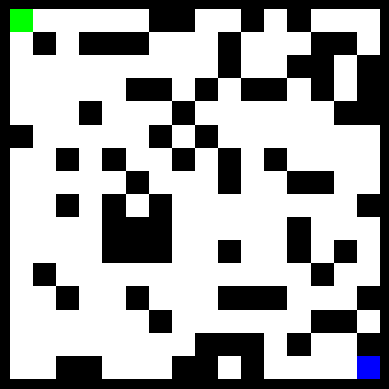

In [17]:
# Plot the grid
import matplotlib.pyplot as plt
import numpy as np
def plot_grid(grid):
    size = len(grid)
    img = np.zeros((size, size, 3), dtype=np.uint8)
    color_map = {'S': (0, 255, 0), 'G': (0, 0, 255), 'F': (255, 255, 255), 'H': (0, 0, 0)}
    for i in range(size):
        for j in range(size):
            img[i, j] = color_map[grid[i][j]]
    plt.imshow(img)
    plt.axis('off')
    plt.show()
plot_grid(grid)

/Users/geraldamasi/PycharmProjects/RL/.venv/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

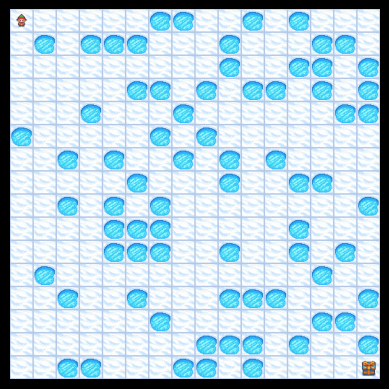

In [20]:
env = gym.make('FrozenLake-v1', render_mode='rgb_array', desc=grid, is_slippery=False)
env.reset()
img = env.render()
plt.imshow(img)
plt.axis('off')

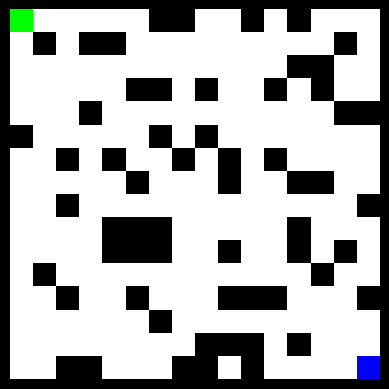

In [66]:
temp_grid = grid.copy()
temp_grid[1][5] = 'F'
temp_grid[1][13]= 'F'
temp_grid[3][10] = 'F'
temp_grid[3][15] = 'F'
temp_grid[2][15] = 'F'
temp_grid[13][14] = 'F'
temp_grid[14][14] = 'F'
temp_grid[13][13] = 'F'
temp_grid[1][9] = 'F'
temp_grid[2][9] = 'F'
temp_grid[8][4] = 'F'
temp_grid[8][6] = 'F'
temp_grid[4][7] = 'F'
temp_grid[14][15] = 'F'
env = gym.make('FrozenLake-v1', render_mode='rgb_array', desc=temp_grid, is_slippery=False)
plot_grid(temp_grid)

In [74]:
Q = np.zeros((state_space, action_space))
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_decay = 0.9999
min_epsilon = 0.01
num_episodes = 50000
for episode in range(num_episodes):
    state, info = env.reset()
    terminated = False
    truncated = False
    while not terminated and not truncated:
        if np.random.rand() < epsilon:
            action = env.action_space.sample()  # Explore
        else:
            action = np.argmax(Q[state])  # Exploit

        next_state, reward, terminated, truncated, info = env.step(action)

        target = reward
        if not terminated:
            target += gamma * np.max(Q[next_state])

        # Q-learning update
        Q[state][action] += alpha * (target - Q[state][action])

        state = next_state
    epsilon = max(min_epsilon, epsilon * epsilon_decay)
optimal_policy = np.argmax(Q, axis=1)

Episode: 5000, Epsilon: 0.6065
Episode: 10000, Epsilon: 0.3679
Episode: 15000, Epsilon: 0.2231
Episode: 20000, Epsilon: 0.1353
Episode: 25000, Epsilon: 0.0821
Episode: 30000, Epsilon: 0.0498
Episode: 35000, Epsilon: 0.0302
Episode: 40000, Epsilon: 0.0183
Episode: 45000, Epsilon: 0.0111
Episode: 50000, Epsilon: 0.0067
Episode: 55000, Epsilon: 0.0041
Episode: 60000, Epsilon: 0.0025
Episode: 65000, Epsilon: 0.0015
Episode: 70000, Epsilon: 0.0009
Episode: 75000, Epsilon: 0.0006
Episode: 80000, Epsilon: 0.0003
Episode: 85000, Epsilon: 0.0002
Episode: 90000, Epsilon: 0.0001
Episode: 95000, Epsilon: 0.0001
Episode: 100000, Epsilon: 0.0001


In [42]:
play_policy(env, optimal_policy, filename='frozenlake-16x16.mp4', fps=2)

In [75]:
optimal_policy

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [92]:
class RewardShapingWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
    def step(self, action):
        next_state, reward, terminated, truncated, info = self.env.step(action)
        row = next_state // self.env.unwrapped.ncol
        col = next_state % self.env.unwrapped.ncol
        tile = self.env.unwrapped.desc[row][col].decode('utf-8')
        if tile == 'G': reward = 10.0
        if tile == 'H': reward = -1.0
        if tile == 'F': reward = 0.1

        reward -= 0.01  # Small step penalty to encourage shorter paths
        return next_state, reward, terminated, truncated, info

In [93]:
env = RewardShapingWrapper(env)

In [97]:
Q = np.zeros((state_space, action_space))
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_decay = 0.9999
min_epsilon = 0.05
num_episodes = 50000
for episode in range(num_episodes):
    state, info = env.reset()
    terminated = False
    truncated = False
    while not terminated and not truncated:
        if np.random.rand() < epsilon:
            action = env.action_space.sample()  # Explore
        else:
            action = np.argmax(Q[state])  # Exploit

        next_state, reward, terminated, truncated, info = env.step(action)

        target = reward
        if not terminated:
            target += gamma * np.max(Q[next_state])

        # Q-learning update
        Q[state][action] += alpha * (target - Q[state][action])

        state = next_state
    epsilon = max(min_epsilon, epsilon * epsilon_decay)
optimal_policy = np.argmax(Q, axis=1)

In [98]:
optimal_policy

array([1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3,
       3, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [99]:
play_policy(env, optimal_policy, filename='frozenlake-16x16-1.mp4', fps=2)

### Now let's try Deep Q Learning with a Neural Network Approximator

In [116]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import numpy as np
import gymnasium as gym

In [137]:
env = gym.make('FrozenLake-v1', render_mode='rgb_array', desc=temp_grid, is_slippery=False)
state_space = env.observation_space.n
action_space = env.action_space.n

In [138]:
class DQN(nn.Module):
    def __init__(self, state_space, action_space):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_space, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_space)
        )
    def forward(self, x):
        return self.net(x)

In [139]:
class ReplayBuffer:
    def __init__(self, capacity=100_000):
        self.buffer = deque(maxlen=capacity)
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return map(np.array, zip(*batch))
    def __len__(self):
        return len(self.buffer)

In [140]:
def one_hot(state, state_space):
    vec = np.zeros(state_space, dtype=np.float32)
    vec[state] = 1.0
    return vec

In [141]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
gamma = 0.99
lr = 1e-3
batch_size = 64
epsilon = 1.0
epsilon_decay = 0.99995
min_epsilon = 0.05
target_update_freq = 1000
num_episodes = 10_000

In [142]:
policy_net = DQN(state_space, action_space).to(device)
target_net = DQN(state_space, action_space).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(policy_net.parameters(), lr=lr)
replay_buffer = ReplayBuffer()

> Now Training loop

In [143]:
step_count = 0
for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    while not done:
        step_count += 1
        if np.random.rand() < epsilon: action = env.action_space.sample()
        else:
            s = torch.tensor(one_hot(state, state_space), dtype=torch.float32).to(device)
            with torch.no_grad():
                action = policy_net(s).argmax().item()
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        replay_buffer.push(one_hot(state, state_space), action, reward, one_hot(next_state, state_space), done)
        state = next_state
        if len(replay_buffer) >= batch_size:
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
            states = torch.tensor(states, dtype=torch.float32).to(device)
            actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(device)
            rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device)
            next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
            dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(device)

            q_values = policy_net(states).gather(1, actions)
            with torch.no_grad():
                next_q_values = target_net(next_states).max(1)[0].unsqueeze(1)
                target_q_values = rewards + (gamma * next_q_values * (1 - dones))

            loss = nn.MSELoss()(q_values, target_q_values)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if step_count % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())
    epsilon = max(min_epsilon, epsilon * epsilon_decay)
    if episode % 5000 == 0:
        print(f"Episode {episode}, Epsilon: {epsilon:.4f}, Replay : {len(replay_buffer)}")

Episode 0, Epsilon: 1.0000, Replay : 5
Episode 5000, Epsilon: 0.7788, Replay : 51621


In [144]:
dqn_policy = np.zeros(state_space, dtype=int)
for s in range(state_space):
    state_vec = torch.tensor(one_hot(s, state_space), dtype=torch.float32).to(device)
    with torch.no_grad():
        dqn_policy[s] = policy_net(state_vec).argmax().item()


In [156]:
dqn_policy

array([1, 2, 3, 2, 2, 1, 0, 0, 3, 3, 1, 3, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 0, 2, 3, 3, 1, 1, 0, 1, 2, 1, 1, 1, 0, 2, 1, 0, 0, 1, 3,
       1, 1, 1, 3, 1, 1, 1, 2, 1, 2, 1, 1, 0, 3, 1, 1, 1, 3, 0, 3, 2, 1,
       1, 1, 1, 2, 2, 3, 0, 0, 3, 3, 3, 1, 1, 1, 3, 2, 2, 1, 0, 0, 1, 3,
       0, 2, 2, 0, 1, 1, 1, 3, 2, 1, 2, 1, 1, 3, 0, 1, 0, 1, 0, 2, 1, 0,
       1, 1, 2, 2, 2, 2, 0, 2, 1, 0, 3, 1, 0, 2, 0, 3, 1, 1, 3, 3, 1, 3,
       0, 2, 2, 0, 0, 3, 1, 1, 2, 1, 3, 0, 3, 3, 1, 1, 3, 3, 3, 3, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 2, 3, 0, 1, 3, 1, 1, 0, 0, 0, 0, 3, 1, 1, 3,
       1, 2, 3, 3, 0, 2, 3, 1, 1, 2, 0, 1, 1, 1, 1, 3, 2, 2, 1, 3, 0, 0,
       1, 1, 3, 0, 1, 1, 1, 1, 1, 3, 1, 0, 2, 3, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 3, 3, 3, 2, 3, 3, 1, 0, 0, 1, 1, 0, 2, 3, 1, 1, 2, 3, 2, 2, 0,
       0, 3, 1, 1, 2, 1, 0, 1, 1, 1, 1, 0, 0, 1])

In [157]:
play_policy(env, dqn_policy, filename='frozenlake-dqn-policy-16x16.mp4', fps=2)

![](frozenlake-dqn-policy-16x16.mp4)